# 1. Loading and Cleaning

## 1.1 Import libraries and python files

In [34]:
#import useful libraries 
import pandas as pd
import json
import sys
import requests
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import calendar
import scipy
import seaborn as sbn
import matplotlib.pyplot as plt
import json
from matplotlib.colors import LogNorm, Normalize
from sklearn.preprocessing import normalize
from datetime import datetime
%matplotlib inline 

from data_loader import *
%load_ext autoreload
%autoreload 2


##link to the datasets
## https://www.cs.cmu.edu/~ark/personas/
##https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=movies_metadata.csv
##https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 Load the different datasets

In [2]:
##load datasets from CMU dataset
df_character = load_character().copy()
df_movie = load_movie().copy()
df_name_cluster = load_name_cluster().copy()
df_summary = load_plot_summary().copy()
df_tropes_cluster = load_tropes_cluster().copy()

In [3]:
# Replace 'id-translation.wikidata.json' with the path to your JSON file
file_path = 'id-translation.wikidata.json'

# Load the JSON file into a DataFrame
df_id_translation = pd.read_json(file_path, orient='records', lines=True)

# Display the loaded DataFrame
# display(df_id_translation)

In [4]:
df_id_translation = df_id_translation.dropna(subset=['Freebase ID'])
df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)

In [5]:
# df_movie will be the reference dataframe. After being completed with additional datasets, it can never be modified

df_movie = pd.merge(df_movie, df_id_translation, on='Freebase ID', how='left')
#display(df_movie)

In [6]:
#compute percentage of missing values for df_movie
values = ['Year', 'Month', 'Box office', 'Runtime', 'tconst']

def compute_missing_values(df, values):
    for variable in values :
        percentage_missing_values = (df[variable].isna().sum()/len(df[variable]))*100
        print(f"The percentage of missing values {variable} release date is {format(percentage_missing_values, '.3f')}%.")

    
compute_missing_values(df_movie, values)


The percentage of missing values Year release date is 8.444%.
The percentage of missing values Month release date is 51.832%.
The percentage of missing values Box office release date is 89.722%.
The percentage of missing values Runtime release date is 25.018%.
The percentage of missing values tconst release date is 9.769%.


In [7]:
##As we can see, a lot of 'Box office' data is missing

## 1.3 Load addtionnal datasets and merge what we need 

In [8]:
#load imdb dataset (from kaggle)
df_imdb_movie = load_movie_imdb_kaggle()
df_imdb_rating = load_rating_imdb_kaggle() 

#merge movies with rating 
df_movie_rating = pd.merge(df_imdb_movie, df_imdb_rating, on='tconst', how='inner')

#display(df_movie_rating)


In [9]:
#merge CMU dataset with IMDB dataset
df_movie = pd.merge(df_movie, df_movie_rating[['tconst', 'averageRating', 'numVotes']], on=['tconst'], how='left')
#display(df_movie)


In [10]:
# missing Rating values
values = ['averageRating', 'numVotes']

compute_missing_values(df_movie, values)
print(f"The number of movies with missing values for 'averageRating' and 'numVotes' is {df_movie['averageRating'].isna().sum()}.")


The percentage of missing values averageRating release date is 31.271%.
The percentage of missing values numVotes release date is 31.271%.
The number of movies with missing values for 'averageRating' and 'numVotes' is 25561.


In [11]:
## load kaggle movie metadata
df_kaggle_movie = load_movie_kaggle()
#display(df_kaggle_movie)

In [12]:
#merge the datasets on the 'Name' column
#df_movie = df_movie.merge(df_kaggle_movie[['Name', 'Year', 'Month', 'Day']], on=['Name', 'Year'], how='left', suffixes=('', '_df2'))
df_movie = df_movie.merge(df_kaggle_movie[['Name', 'Year', 'tconst', 'Month', 'Day']], on=['Name', 'Year','tconst'], how='left', suffixes=('', '_df2'))

In [13]:
#use 'combine_first' to fill in the 'Box office' values from df_kaggle_movie where they are NaN in df_movie
df_movie['Month'] = df_movie['Month'].combine_first(df_movie['Month_df2'])
df_movie['Day'] = df_movie['Day'].combine_first(df_movie['Day_df2'])

#drop the extra 'Box office' column from df_kaggle_movie
df_movie.drop('Month_df2', axis=1, inplace=True)
df_movie.drop('Day_df2', axis=1, inplace=True)
#display(df_movie)

In [14]:

values = ['Year', 'Month', 'Box office', 'Runtime', 'tconst']
compute_missing_values(df_movie, values)


The percentage of missing values Year release date is 8.442%.
The percentage of missing values Month release date is 42.891%.
The percentage of missing values Box office release date is 89.721%.
The percentage of missing values Runtime release date is 25.014%.
The percentage of missing values tconst release date is 9.767%.


In [15]:
#load oscar reward dataset
df_oscar = load_oscar_winner()
#display(df_oscar)

In [16]:
#filter the dataframe to only include rows where 'winner' is True
df_winner_movie = df_oscar[df_oscar['winner'] == True]
#display(df_winner_movie)

In [17]:
df_winner_movie = df_winner_movie.groupby('Name').agg(
    num_oscars_won=pd.NamedAgg(column='winner', aggfunc='size'),
    years_won=pd.NamedAgg(column='year_ceremony', aggfunc=lambda x: list(x))
).reset_index()

#display(df_winner_movie)

In [18]:
#filter the dataframe to only include rows where 'winner' is True
df_winner_movie = df_oscar[df_oscar['winner'] == True]

#group by the movie name and count the winners time
df_winner_movie = df_winner_movie.groupby('Name').agg(
    num_oscars_won=pd.NamedAgg(column='winner', aggfunc='size'),
    years_won=pd.NamedAgg(column='year_ceremony', aggfunc=lambda x: list(x))
).reset_index()

#sort the movies by oscars won
df_oscar_wins = df_winner_movie.sort_values(by='num_oscars_won', ascending=False)

#display(df_oscar_wins)


In [19]:
#merge CUM and oscars awards dataset
df_movie = pd.merge(df_movie, df_oscar_wins, left_on='Name', right_on='Name', how='left')

#replace NaN values in 'num_oscars_won' with 0 for movies that didn't win any oscars
df_movie['num_oscars_won'].fillna(0, inplace=True)

#display(df_movie)

In [20]:
percentage_oascar_movies = ((df_movie['num_oscars_won']!=0).sum()/len(df_movie['num_oscars_won']))*100
print(f"The percentage of movies having won an oscar is {format(percentage_oascar_movies, '.3f')}%.")

The percentage of movies having won an oscar is 1.896%.


## 1.4 Cleanup of the data

In [68]:
# Drop the row with 'Year' smaller than 1800 as we have seen somme erronous movie before and there is too few movies after 2014
df_movie = df_movie[(df_movie['Year'] >= 1800) & (df_movie['Year'] <= 2013)]

# 2. Visualisation and data preprocessing functions 

In [69]:
import scipy
import seaborn as sbn
import matplotlib.pyplot as plt
import json
from matplotlib.colors import LogNorm, Normalize


In [70]:
def count_var(df, var, show_graph=True, show_chisquare=True):
    
    df_temp = df.copy(deep=True)
    df_temp.dropna(subset=[var],inplace=True)

    var_values = df_temp.groupby(var).count()['Name'].values
    
  
    if show_chisquare:
        print(f'Chisquare statistic : {scipy.stats.chisquare(var_values)}')
    if show_graph:
        order=None
        if var == 'Month':
            order = np.linspace(1,12,12).astype(int)
        if var == 'Weekday Name':
            order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        if var == 'Day':
            order = np.linspace(1,31,31).astype(int)
        sbn.set(rc={'figure.figsize':(10,4)})
        
        ax = sbn.countplot(x=var, data=df_temp, order=order)
        
        if var == 'Year':
            plt.xticks(rotation=45, ha='right')
            # Keep only the labels for every five year 
            labels = [item.get_text() for item in ax.get_xticklabels()]
            ax.set_xticklabels([label if int(label) % 5 == 0 else '' for label in labels])

        plt.title(f'Number of movie premieres for category : {var}')
        plt.xlabel(f'{var}')
        plt.ylabel('Number of movies')
        plt.show()
    
    return var_values


def avg_var(df, var='Box office', group='Month', show_graph=True, logscale=True):
    
    df_temp = df.copy(deep=True)
    df_temp.dropna(subset=[group, var],inplace=True)
    
    df_mean = df_temp.groupby(group).mean()[var].values
    df_var = list(df_temp.groupby(group).groups.keys())

    # Graph
    
    if show_graph:
        sbn.set(rc={'figure.figsize':(10,4)})
        order=None
        if group == 'Month':
            order = np.linspace(1,12,12).astype(int)
        if group == 'Weekday Name':
            order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        if group == 'Day':
            order = np.linspace(1,31,31).astype(int)
        # No boxplot for year for now, too much boxplot    
        
        # sbn.barplot(x=df_var, y=df_mean, order = order)
        sbn.boxplot(x=group, y=var, order = order, data=df)
        plt.title(f'{var} for movies by {group}')
        plt.xlabel('Day of the month')
        plt.ylabel(f'Average {var}')
        if logscale:
            plt.yscale("log")
        plt.show()
    
    return df_mean


In [71]:
df_time_stamps = df_movie.copy(deep=True)

df_time_stamps.dropna(subset=['Month'], inplace=True)
temp = (df_time_stamps['Year'].astype(str) + '-' 
                                             + df_time_stamps['Month'].astype(str) + '-' 
                                             + df_time_stamps['Day'].astype(str))


df_time_stamps['Weekday'] = temp.apply(lambda x: pd.to_datetime(x, errors = 'coerce').dayofweek)
df_time_stamps.dropna(subset=['Weekday'], inplace=True)
df_time_stamps['Weekday'] = df_time_stamps['Weekday'].apply(int)


df_time_stamps['Weekday Name'] = temp.apply(lambda x: pd.to_datetime(x, errors = 'coerce')).dt.day_name()

display(df_time_stamps['Weekday Name'].head())
display(df_time_stamps['Weekday'].head())

0        Friday
1     Wednesday
5      Thursday
7       Tuesday
12       Friday
Name: Weekday Name, dtype: object

0     4
1     2
5     3
7     1
12    4
Name: Weekday, dtype: int64

Chisquare statistic : Power_divergenceResult(statistic=2608.7382176521, pvalue=0.0)


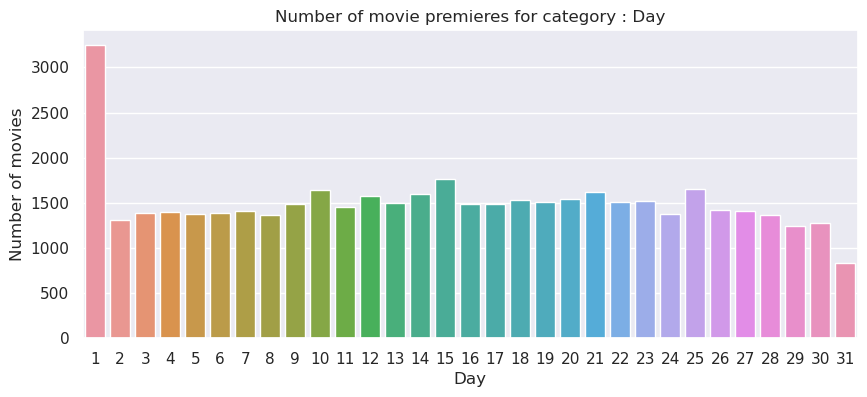

array([3249, 1309, 1387, 1397, 1375, 1388, 1405, 1361, 1482, 1639, 1451,
       1573, 1503, 1603, 1759, 1489, 1487, 1532, 1508, 1544, 1618, 1509,
       1523, 1375, 1658, 1423, 1408, 1363, 1248, 1282,  832])

In [74]:
#count_var(df_movie, 'Day')
#count_var(df_time_stamps, 'Weekday Name')
count_var(df_time_stamps, 'Day')
#avg_var(df_time_stamps, 'Box office', 'Month')

In [26]:
# How many movies of each genre ? 


In [75]:
df_genre_list = df_time_stamps.copy(deep=True)

def get_genres(df):
    genres = dict()
    for i, element in enumerate(df['genres (Freebase ID:name tuples)']):
        t = json.loads(element)
        for v in t.items():
            if v[1] not in genres:
                genres[v[1]] = 0
                #print(genres)
            genres[v[1]] = genres[v[1]] + 1
    return genres

genres = get_genres(df_genre_list)
#genres = sorted(genres)
#print(genres)
#print(len(genres))

In [76]:
def get_movies_genre(df, genre):
    df_temp = df.copy(deep=True)
    df_temp = df_temp[df_temp['genres (Freebase ID:name tuples)'].str.contains(genre)==True] 
    return df_temp

def get_movies_country(df, country):
    df_temp = df.copy(deep=True)
    df_temp = df_temp[df_temp['Countries (Freebase ID:name tuples)'].str.contains(country)==False]
    return df_temp

In [77]:
sorted_genres = sorted(genres.items(), key=lambda x:x[1], reverse=True)
df_movie_genre = df_time_stamps.copy(deep=True)
df_movie_genre.dropna(subset=['Box office'], inplace=True)

n_genre = 20

list_genres = list(dict(sorted_genres).keys())[0:n_genre]

for i in range(10):
    boxoffice_mean = df_movie_genre[df_movie_genre['genres (Freebase ID:name tuples)']
                       .str.contains(sorted_genres[i][0])==True]['Box office'].mean()
    print(f'Average box office for {sorted_genres[i][0]} : {int(boxoffice_mean):,}, which represents {sorted_genres[i][1]:,} movies')


Average box office for Drama : 41,711,679, which represents 21,187 movies
Average box office for Comedy : 52,215,997, which represents 11,330 movies
Average box office for Romance Film : 45,809,834, which represents 7,021 movies
Average box office for Black-and-white : 6,236,742, which represents 6,544 movies
Average box office for Thriller : 71,745,214, which represents 6,237 movies
Average box office for Action : 89,187,861, which represents 5,777 movies
Average box office for Indie : 14,393,350, which represents 4,975 movies
Average box office for Crime Fiction : 51,635,503, which represents 4,719 movies
Average box office for World cinema : 20,251,801, which represents 4,489 movies
Average box office for Short Film : 31,881,762, which represents 4,429 movies


In [78]:
df_genre_list = []
for i in range(n_genre): # todo replace df_movie_genre with df_time_stamps
    temp_df = df_time_stamps[df_time_stamps['genres (Freebase ID:name tuples)']
                             .str.contains(sorted_genres[i][0])==True].copy(deep=True)
    temp_df['Genre'] = sorted_genres[i][0]
    df_genre_list.append(temp_df)

df_movie_genre = pd.concat(df_genre_list)

df_movie_genre.dropna(subset=['Genre'], inplace=True)


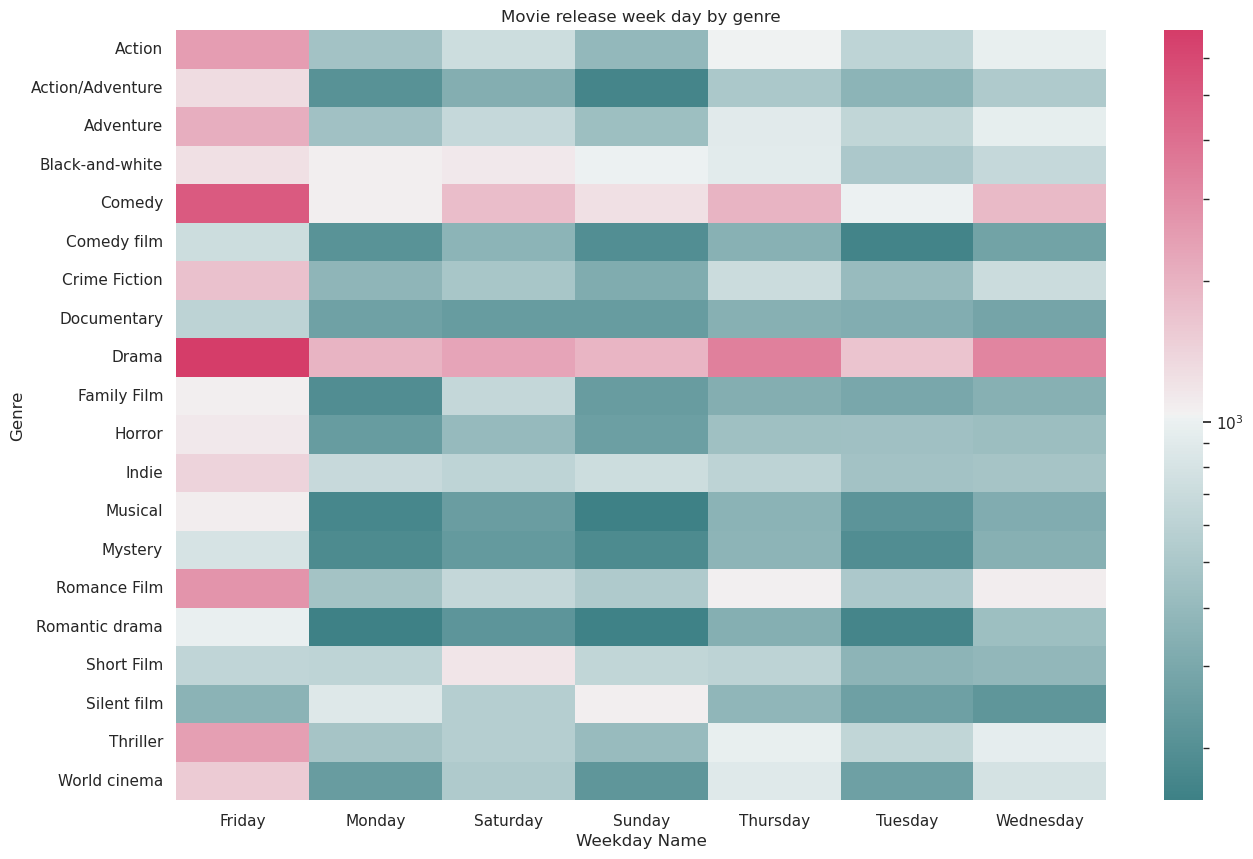

In [79]:
df_genre_weekday = pd.crosstab(df_movie_genre['Genre'],df_movie_genre['Weekday Name'])
plt.subplots(figsize=(15, 10))
sbn.heatmap(df_genre_weekday, annot=False, cmap=sbn.diverging_palette(200, 0, as_cmap=True), norm=LogNorm())
plt.title('Movie release week day by genre')
plt.show()

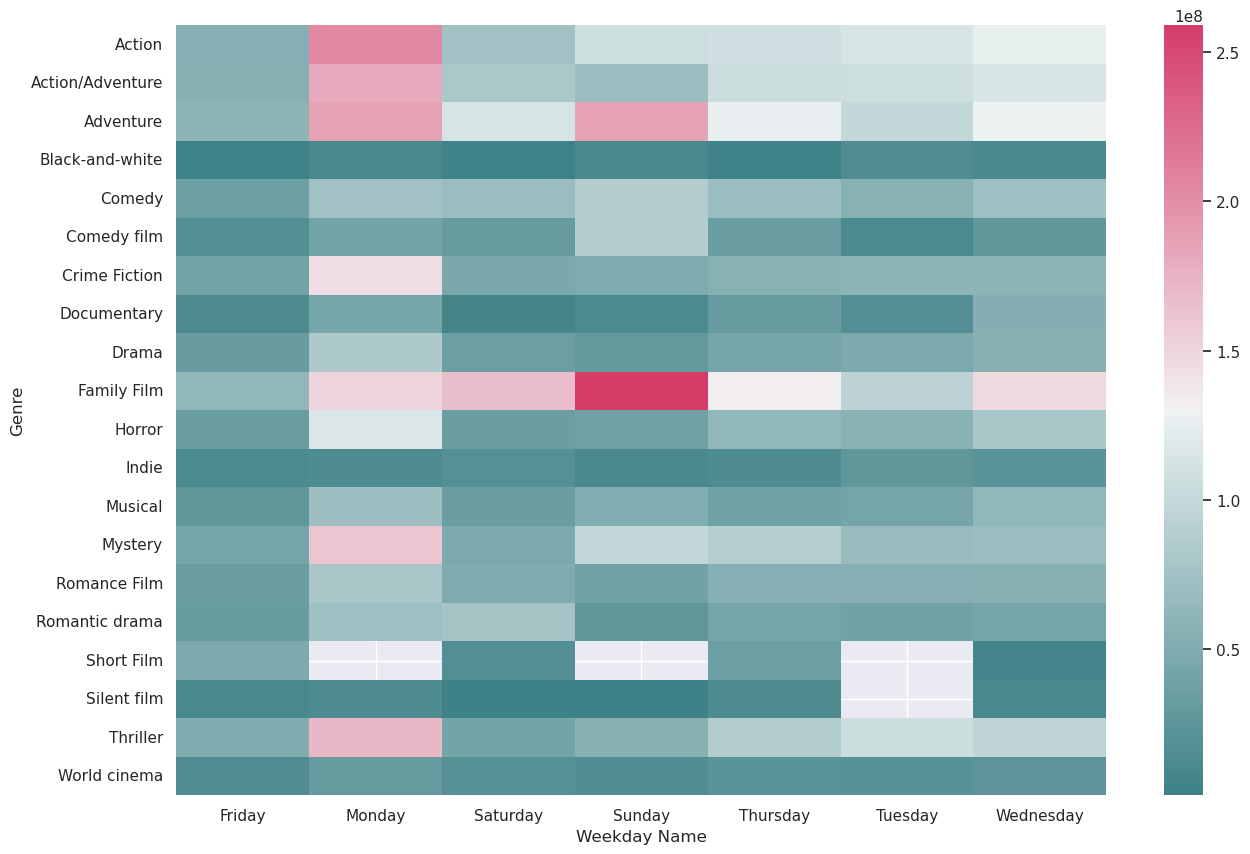

In [80]:
df_movie_genre_boxoffice = df_movie_genre.copy(deep=True)
df_movie_genre_boxoffice.dropna(subset=['Box office'], inplace=True)

df_genre_boxoffice = pd.crosstab(df_movie_genre_boxoffice['Genre'],df_movie_genre_boxoffice['Weekday Name'],
                  values=df_movie_genre_boxoffice['Box office'],aggfunc='mean')

plt.subplots(figsize=(15, 10))
sbn.heatmap(df_genre_boxoffice, annot=False, cmap=sbn.diverging_palette(200, 0, as_cmap=True))
plt.show()

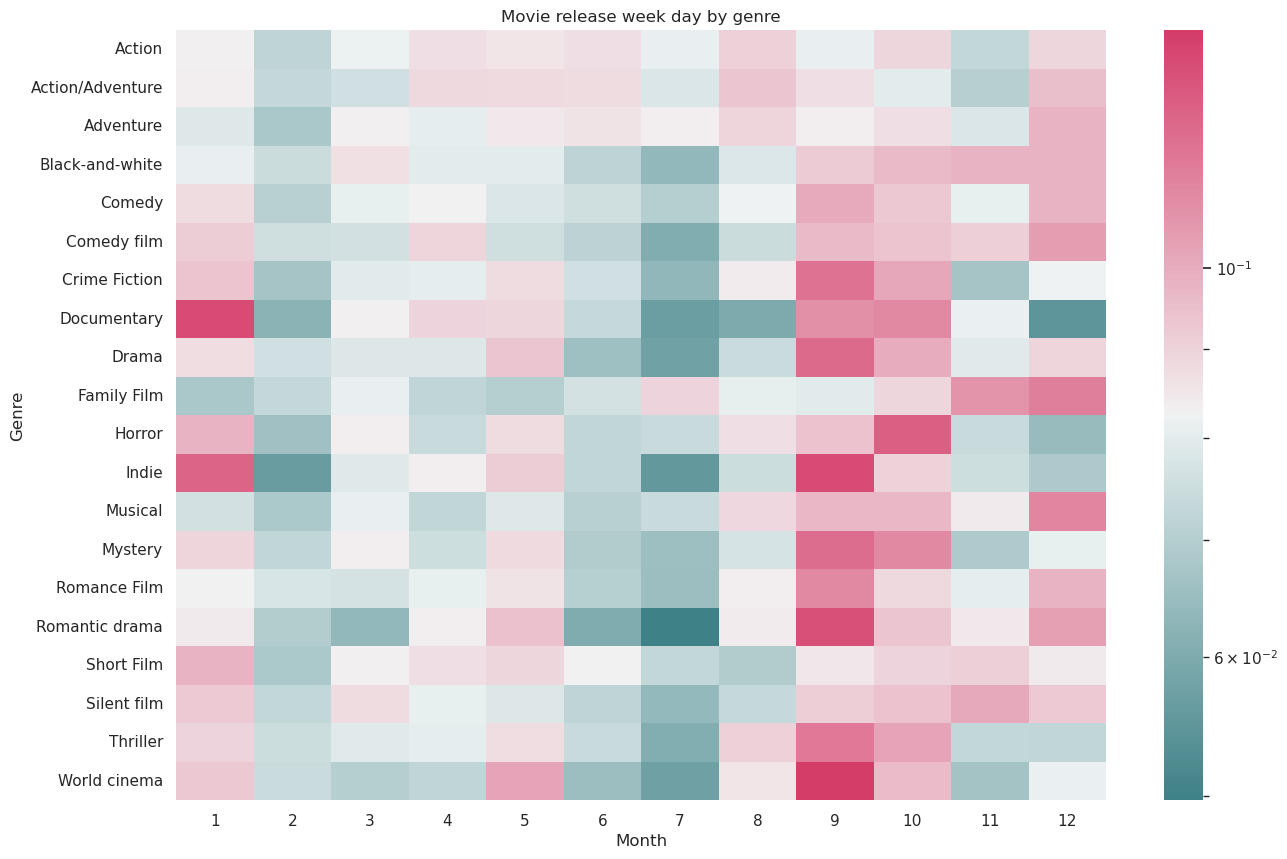

In [81]:
df_genre_month = pd.crosstab(df_movie_genre['Genre'],df_movie_genre['Month'])
normalized_df = pd.DataFrame(normalize(df_genre_month, axis=1, norm='l1'), index=df_genre_month.index, columns=df_genre_month.columns)

plt.subplots(figsize=(15, 10))
sbn.heatmap(normalized_df, annot=False, cmap=sbn.diverging_palette(200, 0, as_cmap=True), norm=LogNorm())
plt.title('Movie release week day by genre')
plt.show()

Chisquare statistic : Power_divergenceResult(statistic=6490.5304087736795, pvalue=0.0)


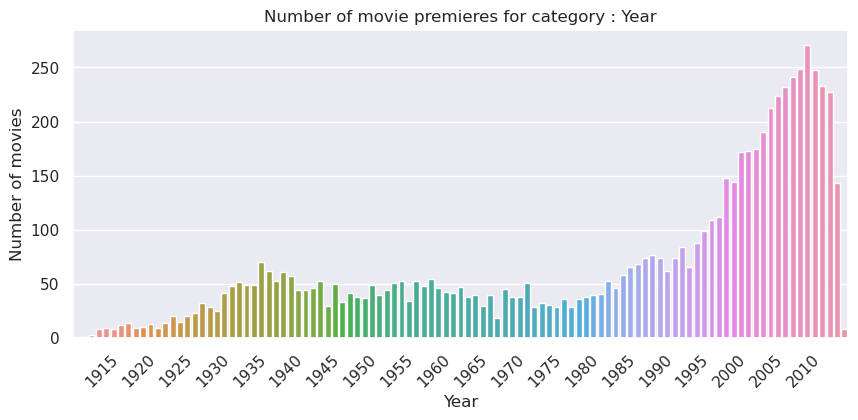

array([  1,   1,   3,   8,   9,   8,  12,  14,   9,  10,  13,   9,  14,
        20,  15,  20,  23,  32,  29,  25,  42,  48,  52,  49,  49,  70,
        62,  53,  61,  57,  44,  44,  46,  53,  30,  50,  33,  42,  38,
        37,  49,  40,  44,  51,  53,  34,  53,  48,  55,  46,  43,  42,
        47,  38,  40,  30,  40,  19,  45,  38,  38,  51,  29,  32,  31,
        29,  36,  29,  36,  38,  40,  41,  53,  46,  58,  66,  68,  74,
        77,  74,  62,  74,  84,  66,  88,  99, 109, 112, 148, 144, 172,
       173, 175, 190, 213, 224, 232, 241, 249, 271, 248, 233, 227, 143,
         8])

In [82]:
genre = 'Romance Film'
genre_movie = df_movie_genre.groupby('Genre').get_group(genre)

count_var(genre_movie, 'Year')

We need to normalize the data (as we can easily suppose that there were more film nowadays than before

In [83]:
def count_var_normalized_genre(initial_df, genre_df, var, show_graph=True, show_chisquare=True):

    df_genre_temp = genre_df.copy(deep=True)
    df_total_temp = initial_df.copy(deep=True)
    
    df_genre_temp.dropna(subset=[var],inplace=True)
    df_total_temp.dropna(subset=[var],inplace=True)

    genre_values = df_genre_temp.groupby(var).count()['Name']
    total_values = df_total_temp.groupby(var).count()['Name']
    
    proba = ((genre_values/ total_values) * 100).fillna(value= 0)
    proba_values = proba.values
    
  
    if show_chisquare:
        print(f'Chisquare statistic : {scipy.stats.chisquare(proba_values)}')
    if show_graph:
        order=None
        if var == 'Month':
            order = np.linspace(1,12,12).astype(int)
        if var == 'Weekday Name':
            order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        if var == 'Day':
            order = np.linspace(1,31,31).astype(int)
        sbn.set(rc={'figure.figsize':(10,4)})
        
        ax = sbn.barplot(x=proba.index, y=proba.values)
        
        if var == 'Year':
            plt.xticks(rotation=45, ha='right')
            # Keep only the labels for every five year 
            labels = [item.get_text() for item in ax.get_xticklabels()]
            ax.set_xticklabels([label if int(label) % 5 == 0 else '' for label in labels])

        plt.title(f'Percentage of movie premieres for category : {var}')
        plt.xlabel(f'{var}')
        plt.ylabel('Percentage of movies')
        plt.show()
    
    return proba_values

Chisquare statistic : Power_divergenceResult(statistic=251.9386896367251, pvalue=1.388513782622308e-10)


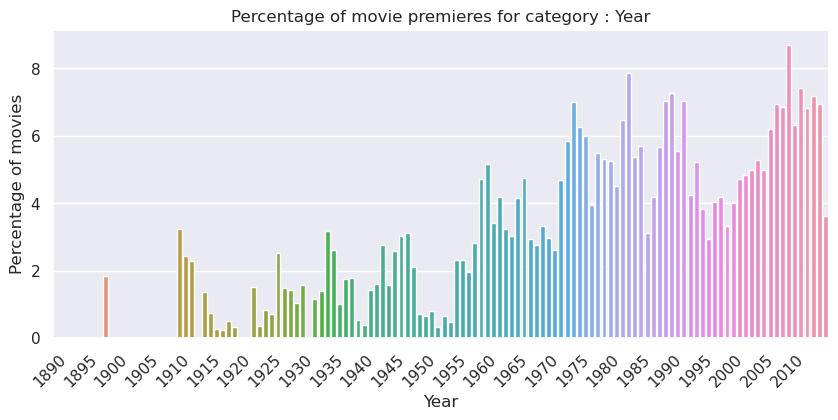

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.85185185, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       3.22580645, 2.43902439, 2.27272727, 0.        , 1.36986301,
       0.73529412, 0.27322404, 0.23866348, 0.49875312, 0.3236246 ,
       0.        , 0.        , 1.52905199, 0.36630037, 0.84033613,
       0.71942446, 2.53623188, 1.47058824, 1.42348754, 1.02739726,
       1.58227848, 0.        , 1.14942529, 1.3986014 , 3.16742081,
       2.60303688, 0.99800399, 1.76470588, 1.7921147 , 0.54744526,
       0.38610039, 1.43737166, 1.6064257 , 2.76008493, 1.58415842,
       2.5862069 , 3.03030303, 3.11688312, 2.09973753, 0.72815534,
       0.65502183, 0.80645161, 0.33726813, 0.64620355, 0.46656299,
       2.3297491 , 2.30326296, 1.96779964, 2.80701754, 4.72027972,
       5.15097691, 3.42857143, 4.17457306, 3.24427481, 3.02491

In [84]:
genre = 'Horror'
genre_movie = df_movie_genre.groupby('Genre').get_group(genre)

count_var_normalized_genre(df_movie, genre_movie,'Year')

# 3. Research on release month and revenues 

## 3.0 Methology


-Can we find any trends in movie release dates within a year? Do these trends change across countries ? across history ?

We mainly use regression method to find whether there exists some relationship between 'release month' and 'Box office'.
The following is function we use:
$$Y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_{11}x_{11}$$

$Y$ = Box office \
$X$ = Dummies variable of release month (Note: here we use December as bench mark)

In section 3.1 we regress box office on dummies varibles of release month for the whole data set. 

In section 3.2 we regress box office on dummies varibles of release month with respect to different countries. Note that in section 2, we only choose the countries with more than 200 datasets, because it will lack of accuracy due to insufficient samples.

In section 3.3, we regress box office on dummies variables of release month with respect to consecutive time periods (i.e. 1920-1940, 1940-1960, 1960-1980, 1980-2000, 2000-2012)


## 3.1 Regressing 'Box office' on 'month release'

### 3.1.1 Clean the data
1. Deep copy the df_movie data set
2. Drop 'nan' row for box office and Month columns.
3. Drop the row with 'Year' smaller than 1800.

In [85]:
# Deep copy the data set
df_movie_month = df_movie.copy(deep=True)

# Drop 'nan' row of box office and month release columns.
df_movie_month.dropna(subset = ['Box office', 'Month'], inplace = True)

### 3.1.2 Regressing box office on release month for all data. 
Note that we will store the coefficients and the corresponding t-values. And then we will visualize them on section 3.2

In [86]:
# Use w as a dictionary to store the coefficient.
w = {}

# Build up dependent varibale
movie_revenues = df_movie_month['Box office'].values

# Build up independent variable
month_release = pd.get_dummies(df_movie_month['Month']).values
# Remove one month column to select it as a baseline here December
month_release = month_release[:, :-1].astype(int)
month_release = sm.add_constant(month_release)

# Regress Box officie on release month for all data and store coefficient and and t-values
model = sm.OLS(movie_revenues, month_release).fit()
w['ALL'] = [model.params, model.tvalues]

## 3.2 Regressing 'Box office' on 'month release' for different countries

### 3.2.1 Get the list of countries

In [87]:
def get_list_of_countries(df_series):
    """This is the function to get the list of countries' name from a dataframe series.

    Args:
        df_series (data frame series): the column of data frame series include the countries name

    Returns:
        list_of_countries (list): list of countries name
    """
    #The following step is to find the list of all the countries name which is show in the 'Countries (Freebase ID:name tuples)' column
    # Define a function to extract country names
    def extract_countries(location):
        # Convert the string to a dictionary
        location_dict = json.loads(location.replace("'", "\""))
        # Extract and return the country names
        return list(location_dict.values())
    #transfer the text of 'Countries (Freebase ID:name tuples)' into some string only contain the countries name
    df_aux = df_series.apply(extract_countries)
    df_aux = pd.DataFrame(df_aux.apply(lambda x: ', '.join(x) if x else None))
    df_aux = df_aux.dropna()
    #list the unique countries name.
    list_of_countries = df_aux['Countries (Freebase ID:name tuples)'].unique()
    string_of_countries = ','.join(list_of_countries)
    list_of_countries = string_of_countries.split(',')
    list_of_countries = [x.strip() for x in list_of_countries]
    list_of_countries = list(set(list_of_countries))
    return list_of_countries

list_of_countries = get_list_of_countries(df_movie_month['Countries (Freebase ID:name tuples)'])

# Drop the name with direction (e.g west, south, east, north), except the countries like South Africa.

# Build up the ['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']
direction = ['South','North','West','East']
direction_2 = [x.lower() for x in direction]
di = direction + direction_2
display(di)

# To see which name of the courties contain ['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']
for i in list_of_countries:
    if any(substring in i for substring in di):
        print(i)
        
# Delete south korea and west germany
list_of_countries.remove('South Korea')
list_of_countries.remove('West Germany')

['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']

West Germany
South Africa
South Korea


### 3.2.2 Regression for each countries

In [88]:
# We regress box office on dummies varibles of release month with respect to different countries. 
# Note that in section 2, we only choose the countries with more than 200 datasets.
for country in list_of_countries:
    index_of_data = df_movie_month['Countries (Freebase ID:name tuples)'].str.contains(country)
    if index_of_data.sum() >= 200:
        model = sm.OLS(df_movie_month[index_of_data]['Box office'].values, month_release[index_of_data,:]).fit()
        w[country] = [model.params, model.tvalues]

### 3.2.3 Visualize all the results

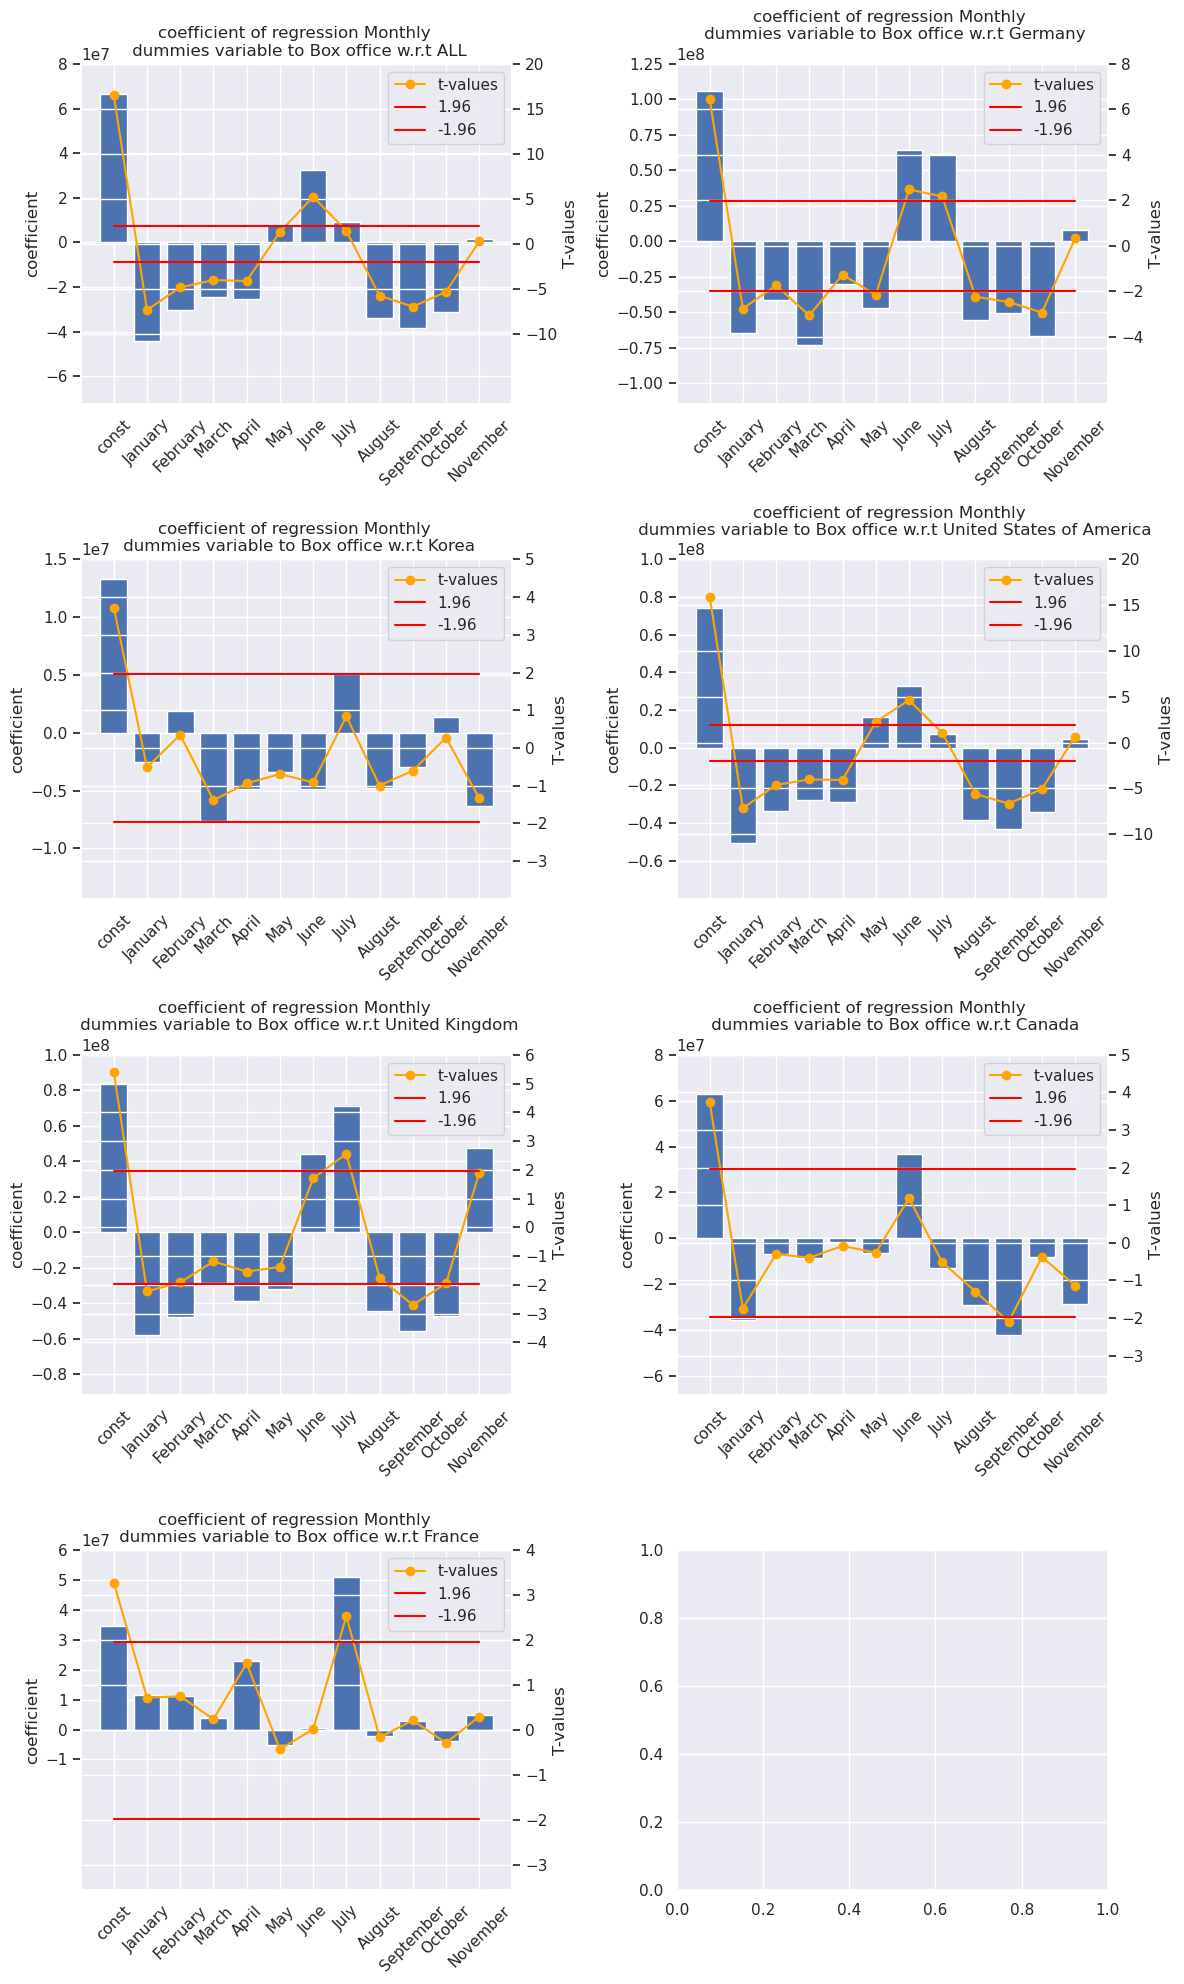

In [89]:
# Generate a list of month names
months = list(calendar.month_name)[1:]
months = months[:-1]
months.insert(0, 'const')


def box_month_plot(height, width, dictionary, months, f_h, f_w):
    """Plot the coefficient of regression

    Args:
        height (int): number of subplot in vertical axis
        width (int): number of subplot in horizontal axis
        dictionary (dict): dictionary to store the coefficient and t-values
        months (list): list of month
        f_h (int): height of figure size
        f_w (int): wight of figure size 
    
    """
    # Create a subplot with 4 rows and 2 columns
    fig, axes = plt.subplots(height, width, figsize=(f_h, f_w))
    axes = axes.flatten()

    # Create bar charts for each country
    for i, name in zip(np.arange(0,height*width),dictionary.keys()):
        ax = axes[i]
        ax.bar(months, dictionary[name][0])
        if isinstance(name,int) or isinstance(name,np.int64) :
            ax.set_title('coefficient of regression Monthly \n dummies variable to Box office w.r.t {}-{}'.format(name, name+20))
        else:
            ax.set_title('coefficient of regression Monthly \n dummies variable to Box office w.r.t {}'.format(name))
        ax.set_xticks(range(len(months)))
        ax.set_xticklabels(months, rotation=45)
        ax.set_ylabel('coefficient')
        ax2 = ax.twinx()
        
        # Plot the t-values and 1.96 and -1.96 to check whether the coefficient is significant.
        ax2.plot(months, dictionary[name][1], color='orange', marker='o', label='t-values')
        ax2.plot(months, 12*[1.96], color='red', label='1.96')
        ax2.plot(months, 12*[-1.96], color='red', label='-1.96')
        ax2.set_ylabel('T-values')
        ax2.legend(loc='upper right')
        
        # Align the zero point for the left y-axis and right y-axis.
        aL, aaL = ax.get_ylim()
        aR, aaR = ax2.get_ylim()
        Left = ax.get_yticks()
        Right = ax2.get_yticks()
        aaL = max(aaL,abs(aL))
        aL = min(-aaL,aL)
        aaR = max(aaR,abs(aaR))
        aR = min(-aaR,aR)
        ax.set_ylim(aL,aaL)
        ax2.set_ylim(aR,aaR)
        ax.set_yticks(Left)
        ax2.set_yticks(Right)

    plt.tight_layout()
    plt.show()
    
box_month_plot(4, 2, w, months, 12, 20)

### What we find?
Note: 

Indeed, we find some trend. For overall data and each of the countries, it is significantly that if the movie was release on July it would have higher Box Office than that of the other month. For the release date from January to May and from August to October, almost all the countries have lower Box Officer than the bench mark (i.e. December's Box Office). It is worth noting that the average Box offcier on July is way more higher than the other months in France. 

## 3.3 Regressing 'Box office' on 'month release' for each continuous 20-year time span.

In [90]:
# Take a look at the release year of the movies. 
np.sort(df_movie_month['Year'].unique())

array([1897, 1914, 1915, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012], dtype=object)

In [91]:
# Get the time interval
year_list = 1900 + np.arange(0,121,20)
year_list[0] = df_movie_month['Year'].min()

# Use w_over_twenty_year as a dictionary to store the coefficient
w_over_twenty_year = {}

# Regress box office on release month over the time interval
for i in np.arange(0,len(year_list)-1):
    df = df_movie_month [ (df_movie_month["Year"] >= year_list[i]).values and (df_movie_month["Year"] < year_list[i+1]).values]
    
    # Build up dependent variable (Box office) with respect to different time interval
    movie_revenues = df['Box office'].values
    
    # Build up independent variable (dummies varible of release month) with respect to different time interval
    month_release = pd.get_dummies(df['Month']).values
    month_release = month_release[:, :-1].astype(int)
    month_release = sm.add_constant(month_release)
    
    # Regress box office on release month over the time interval
    # And store the coefficients and corresponding t-values
    model = sm.OLS(movie_revenues, month_release).fit()
    w_over_twenty_year[year_list[i]] = [model.params, model.tvalues]


# Drop the time interval with coefficient less than 12.
store_name = []
for name in w_over_twenty_year.keys():
   if len(w_over_twenty_year[name][0]) < 12:
       store_name.append(name)
for name in store_name:
    del w_over_twenty_year[name]

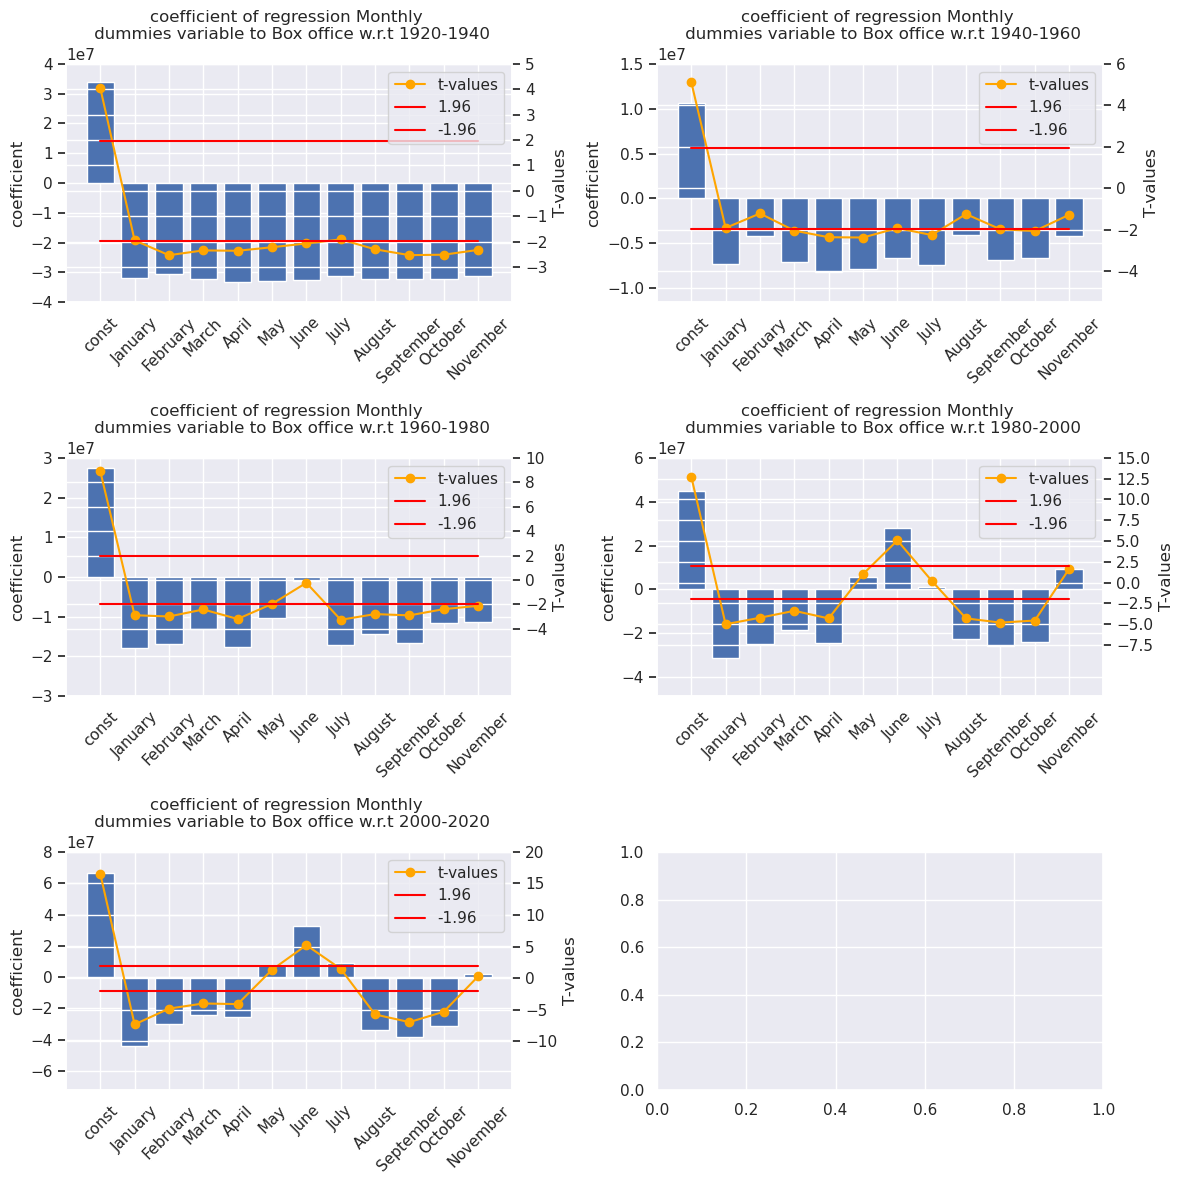

In [92]:
box_month_plot(3, 2, w_over_twenty_year, months, 12, 12)

We find something weird that if we release the movies on December it would be higher than the other months with rolling window of 20 years from 1920 to 1980 on average. It could be a interest topic.

The following step is to add some new independent variables like genre to see if the dummies variable of release month still significant. In other words, we need to add more independent variables to find the 'confounder'.

# 4. PCA anaysis 

Here is a first draft of the principal component analysis of our data.

In [93]:
#converting the year, month and day values into a datetime format and the week number of the release date
df_movie_PCA = new_date_format(df_movie)

NameError: name 'new_date_format' is not defined

In [94]:
#count the number of movies coming out each week number each year 
movie_count_df = df_movie_PCA.groupby(['Year', 'Week_Number']).size().reset_index(name='Movie_Count')
#pivot the dataframe to create an array
movie_array = movie_count_df.pivot(index='Year', columns='Week_Number', values='Movie_Count').fillna(0).astype(int)
#select a subset of year to get more consistent results
movie_array = movie_array[(movie_array.index >= 1980) & (movie_array.index <= 2011)]
#change to observe other year
selected_year = 1980
#extract the row for the selected year
selected_year_row = movie_array.loc[selected_year]

#plot a histogram
plt.bar(selected_year_row.index, selected_year_row)
plt.xlabel('Week Number')
plt.ylabel('Number of Movies')
plt.title(f'Distribution of Movies in {selected_year}')
plt.show()

NameError: name 'df_movie_PCA' is not defined

We look here at the number of movies coming out each week in 1980

In [ ]:
#computing the covariance matrix our our movies numbers across years
movie_array_val = movie_array.values
cov_matrix = np.cov(movie_array_val.T)
sns.heatmap(cov_matrix)

The covariance matrix shows us the weeks of important common variance in movie releases

In [ ]:
#computing the singular value decomposition
U, S, VT = np.linalg.svd(cov_matrix)
#choosing the number of components
nb_comp = 2
#taking the eigenvectors and eigenvalues
U_top = U[:, :nb_comp]
S_top = np.diag(S[:nb_comp])
VT_top = VT[:nb_comp, :]
#projecting our data on new coordinates
projected_data = np.dot(movie_array, U_top)
main_variations = np.dot(projected_data, U_top.T)

The Singular Value Decomposition is a standard decomposition techniques which gives us the eigenvectors and eigenvalues of our covariance matrix. These will be our principal components, ordered by variance explained. Then by projecting our original data on a certain number of components we get to see the points of common variance across years.

In [ ]:
#plotting the PCA of our data projected onto two principal components
fig, ax = plt.subplots(figsize=(15, 8))
for i in range(32):
    ax.plot(main_variations[i], label=f'Year {i + 1980}')

ax.set_xlabel('Week number')
ax.set_ylabel('Projected number of movies')
ax.set_title('PCA on movie release data of movies between 1980 and 2011')
ax.legend()
ax.grid(which='both')
plt.show()

With further analysis, by looking at specific countries, genres and periods we'll be able to observe shared trends in movie releases that we could've missed otherwise.

# 5. Oscars analysis

In [ ]:
#load oscar reward dataset
df_oscar = load_oscar_winner()
display(df_oscar)

In [ ]:
#load file with ceremony dates
df_date_ceremony = pd.read_csv('oscars_ceremony_dates.csv')
#filter the dataframe to only include rows where 'winner' is True
df_winner_movie = df_oscar[df_oscar['winner'] == True]
#merge the datasets on ceremony number
df_winner_movie = pd.merge(df_winner_movie, df_date_ceremony, on='ceremony', how='left')

In [ ]:
#group by the movie name and count the winners time
df_winner_movie = df_winner_movie.groupby('Name').agg(
    num_oscars_won=pd.NamedAgg(column='winner', aggfunc='size'),
    date_won=pd.NamedAgg(column='date', aggfunc=lambda x: list(x))
).reset_index()
#sort the movies by oscars won
df_oscar_wins = df_winner_movie.sort_values(by='num_oscars_won', ascending=False)

In [ ]:
#merge CMU and oscars awards dataset
df_movie_oscars = pd.merge(df_movie, df_oscar_wins, left_on='Name', right_on='Name', how='left')
#replace NaN values in 'num_oscars_won' with 0 for movies that didn't win any Oscars
df_movie_oscars['num_oscars_won'].fillna(0, inplace=True)
#extracting only the movies who won at least 1 oscar
only_winners = df_movie_oscars[(df_movie_oscars['num_oscars_won'] > 0)]
#using our function to get additionnal information
only_winners = new_date_format(only_winners)

In [ ]:
#looking at average number of oscars won by movies which came out each week
average_oscar_per_week = only_winners.groupby('Week_Number')['num_oscars_won'].mean()
average_oscar_per_week_array = average_oscar_per_week.values
weeks = np.arange(0,53)
#computing a linear regression to highlight particular trends
coefficients = np.polyfit(weeks, average_oscar_per_week_array, 1)
linear_fit = np.poly1d(coefficients)

plt.plot(average_oscar_per_week_array)
plt.axvline(x=12, color='red', linestyle='--', label='Oscar season begins')
plt.plot(weeks, linear_fit(weeks), color='red', label='Linear Regression')